## 목차
1. 프레임워크 & 데이터 불러오기
   - 왜 외계인처럼 나오는가?
2. 얼굴을 인식해보자(Face detection)
   - Problem : Bounding Box Too Small
3. Landmark 모델 가져오고, 얼굴 랜드마크 확인하기
4. 수염을 불러오기
5. 스티커 적용
   - Problem : 고양이 코 사진 흰 배경 없어지지 않는다? 


회고 :  배경 없애는 것 생각 외로 간단한 문제여서 감사하고 허탈했다.

## 1. 프레임워크 & 데이터 불러오기 

In [1]:
# 프레임워크 불러오기
import os
from os.path import join
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib 

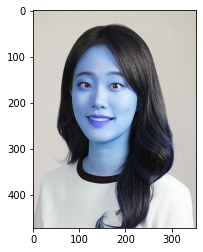

In [2]:
# my_image_path = 'aiffel/camera_sticker/images/image.png' # 나의 사진
my_image_path ='/aiffel/aiffel/camera_sticker/images/dam.png'
# data_dir = os.getenv('HOME')+ 'aiffel/camera_sticker/images'
# my_image_path = join(data_dir, 'dam.png')

img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 이미지 복사
plt.imshow(img_bgr) # 이미지 확인
plt.show() 

- 오류 기록 : 왜인지는 정확히 파악이 필요한데 "aiffel"폴더를 두번 호출해야 사진 경로 오류가 발생하지 않았다.
- 의문 : Home폴더명이 aiffel일까? 
---
- 오류 메시지 : NoneType' object has no attribute 'copy'
- 사용 경로(오류) : '/aiffel/camera_sticker/images/dam.png'
- 사용 경로(해결) : '/aiffel/aiffel/camera_sticker/images/dam.png'

In [3]:
import os
print(os.path.exists(my_image_path))  # 이미지 파일이 경로에 존재하는지 확인


True


### 왜 외계인처럼 나오는가?
- opencv는 RGB가 아닌 BGR(파랑, 녹색, 빨강) 사용! 
- RGB로 변환하여 생기를 불어 넣어 보겠다.

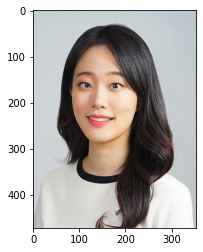

In [4]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) 
plt.imshow(img_rgb)  # 사용할 이미지를 올려두기
plt.show()           # 사용할 이미지 출력

## 2. 얼굴을 인식해보자(Face detection)
- 열굴 요소를 인식하기 위해, '얼굴탐지기 매서드'로 얼굴이 있는 범위를 지정해준다
- 얼굴이 있는 범위는 이후 `Object keypoint estimation`알고리즘에서 사용할  "Bounding box"이다

In [5]:
detector_hog = dlib.get_frontal_face_detector() # 기본 얼굴 감지기를 반환

In [6]:
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid) 
# FYI : image pyramid = upsampling

In [7]:
"""
print(dlib_rects)   

for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left()   # 왼쪽
    t = dlib_rect.top()    # 위쪽
    r = dlib_rect.right()  # 오른쪽
    b = dlib_rect.bottom() # 아래쪽

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) 
    # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림 
    # bounding box 찾기
"""

'\nprint(dlib_rects)   \n\nfor dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표\n    l = dlib_rect.left()   # 왼쪽\n    t = dlib_rect.top()    # 위쪽\n    r = dlib_rect.right()  # 오른쪽\n    b = dlib_rect.bottom() # 아래쪽\n\n    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) \n    # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림 \n    # bounding box 찾기\n'

In [8]:
"""
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()
"""

'\nimg_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)\nplt.imshow(img_show_rgb)\nplt.show()\n'

#### Problem : Bounding Box Too Small
- bounding box 너무 작다. 턱이 안들어왔다 => (해결완료) margin 추가

In [9]:
# margin 추가
margin = 20 # 10, 12, 15

print(dlib_rects)   

for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left()   # 왼쪽
    t = dlib_rect.top()    # 위쪽
    r = dlib_rect.right()+margin  # 오른쪽
    b = dlib_rect.bottom()+margin # 아래쪽

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) 
    # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림 
    # bounding box 찾기

rectangles[[(64, 116) (218, 270)]]


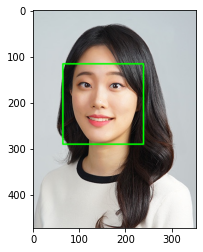

In [10]:
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

=> bounding box 확장 성공

## 3. Landmark 모델 가져오고, 얼굴 랜드마크 확인하기
- Dlib의 제공되는 landmark모델을 사용한다
- shape_predictor로 모델 불러온다
- 모델은 RGB이미지와 Bounding box를 받고, box내 face landmark 구성요소(눈,코,입 등)와 위치(박스내위치 및 이미지상위치) 등을 찾아놓는다

In [11]:
model_path = '/aiffel/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [12]:
list_landmarks = []
print(len(list_landmarks))

0


In [13]:
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
        # 모든 landmark의 위치정보를 points 변수에 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        # 각각의 landmark 위치정보를 (x,y) 형태로 변환하여 list_points 리스트로 저장
    list_landmarks.append(list_points)
        # list_landmarks에 랜드마크 리스트를 저장

print(len(list_landmarks[0])) 
# 모델 데이터셋, 68개 확인 
# 얼굴이 1개라서 list_landmarks[1]는 없다

68


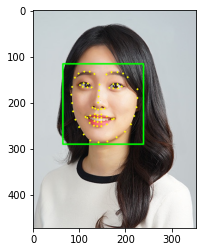

In [14]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # cv2.circle: OpenCV의 원을 그리는 함수

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB) # RGB 이미지로 전환
plt.imshow(img_show_rgb)
plt.show() # 이미지를 출력

## 4. 수염 불러오기

In [15]:
# → rectangles[[(64, 116) (218, 270)]] # left(), top(), right(), bottom()

for dlib_rect, landmark in zip(dlib_rects, list_landmarks): # 얼굴 영역 값(dlib_rects)과 68개의 랜드마크(list_landmarks)값으로 반복문 실행
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]  # 이미지에서 코 부위의 x값
    y = landmark[30][1] - dlib_rect.height()// 2 
    w = h = dlib_rect.width() # → max(x) - min(x) +1
    print (f'(x,y) : ({x},{y})')
    print (f'(w,h) : ({w},{h})')

(140, 200)
(x,y) : (140,123)
(w,h) : (155,155)


In [16]:
sticker_path = '/aiffel/aiffel/camera_sticker/images/cat-whiskers.png'  # 고양이수염
img_sticker = cv2.imread(sticker_path) # 수염을 불러옵니다
img_sticker = cv2.resize(img_sticker, (w-5,h-5)) # 스티커 이미지 조정 
# img_sticker = img_sticker.shape
# print (img_sticker)
print (img_sticker.shape) # 사이즈를 조정한 수염

(150, 150, 3)


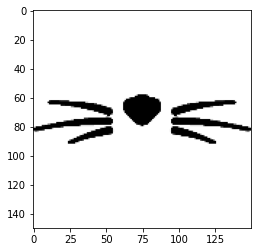

In [17]:
plt.imshow(img_sticker)
plt.show() # 이미지를 출력

In [18]:
refined_x = x - w // 2 
refined_y = y - h      
print(refined_x, refined_y) 

63 -32


In [19]:
# 음수값 만큼 수염 이미지 자른다.
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 64
# 수염 씌우기 위해 수염 이미지가 시작할 y좌표 값 조정
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :] 
    # refined_y = 0
    refined_y = 150
print(refined_x, refined_y) # 

63 150


## 5. 스티커 적용

In [20]:
print(y, img_sticker.shape[0], refined_y, refined_y+img_sticker.shape[0])
print(x, img_sticker.shape[1], refined_x, refined_x+img_sticker.shape[1])


123 118 150 268
140 150 63 213


In [21]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
        np.where(img_sticker != 0, sticker_area, img_sticker).astype(np.uint8)


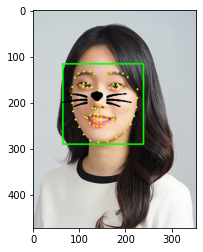

In [22]:
# 확인
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

#### Problem : 고양이 코 사진 흰 배경 없어지지 않는다?

In [23]:
# Problem : 고양이 코 사진 흰 배경 없어지지 않는다?
"""
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
        np.where(img_sticker == 1, sticker_area, img_sticker).astype(np.uint8)
 
 
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()
"""

'\nsticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]\n\nimg_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] =         np.where(img_sticker == 1, sticker_area, img_sticker).astype(np.uint8)\n \n \nplt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))\nplt.show()\n'